In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import simgraph.my_simgraph as sg
import dataprocess.data_handler_03 as dh

In [25]:
import importlib
importlib.reload(dh)

<module 'dataprocess.data_handler_03' from '/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages/dataprocess/data_handler_03.py'>

# Load and group neuron spike data

In [15]:
# load all spike data from file
spikes_dp = '../../../local_data/original_files/'
grouped_data = np.load(spikes_dp+'summed_spikes.npy') # you can load alternative files from the same directory

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [16]:
grouped_data.shape

(297, 1141, 1)

In [17]:
# visualize the response data
length = grouped_data.shape[0] * grouped_data.shape[1]
lbl_min = int(np.min(grouped_data))
lbl_max = int(np.max(grouped_data))
print('labels range from {} to {}.'.format(lbl_min, lbl_max))

print('label      | percentage belonging to label   ')
print('---------------------------------------------')
sanity = 0
for lbl in range(lbl_min, lbl_max+1):
    class_perc = 100*float(sum(sum(grouped_data == lbl))) / length
    print('label #{:3} | {:.2f} %'.format(lbl, class_perc))
    sanity += class_perc

print("total percentage (should be %100): ", sanity)

labels range from 0 to 26.
label      | percentage belonging to label   
---------------------------------------------
label #  0 | 31.53 %
label #  1 | 15.38 %
label #  2 | 8.77 %
label #  3 | 7.07 %
label #  4 | 6.27 %
label #  5 | 5.61 %
label #  6 | 4.82 %
label #  7 | 4.22 %
label #  8 | 3.67 %
label #  9 | 3.12 %
label # 10 | 2.60 %
label # 11 | 2.07 %
label # 12 | 1.61 %
label # 13 | 1.19 %
label # 14 | 0.80 %
label # 15 | 0.52 %
label # 16 | 0.31 %
label # 17 | 0.18 %
label # 18 | 0.11 %
label # 19 | 0.06 %
label # 20 | 0.04 %
label # 21 | 0.02 %
label # 22 | 0.01 %
label # 23 | 0.01 %
label # 24 | 0.00 %
label # 25 | 0.00 %
label # 26 | 0.00 %
total percentage (should be %100):  100.00000000000003


# Create training and validation datasets

In [27]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::4]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::200]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]

def transform_soenet(fv):
    return fv[::5]

# data retrieval params
# data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
#                'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1_with_kp/desc/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/soenet/soenet3/features_2layer/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform_soenet, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'soenet'}

In [47]:
train_num = 200
val_num = 50

train_num, val_num, train_data, val_data = \
dh.random_train_val(train_num, val_num, data_params, seed=0)

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])

print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  soenet
train_num =  200 , val_num =  50
number of features:  80
train_smpls =  [1920 2110 1305 1405 1280 1982 2134 1589 1260 1771 1864 1514 2005 2185
 1616 1448 1377 1558 1572 1799 1526 1735 1293 2152 2114 1375 2174 1238
 1733 1686 1617 1790 1661 1808 1253 1426 1653 1474 1318 1844 1706 1261
 1854 1968 1951 1604 1925 1763 1516 1483 1189 1254 1504 2088 2139 1840
 2233 1730 2155 2207 2078 1329 2256 1609 1880 1722 1326 1343 2130 2231
 1981 1928 1630 2138 1445 1527 1824 1896 1378 1933 2020 2232 1608 1186
 2268 1196 1482 1410 1212 2026 2204 2183 1973 1340 1537 2104 2278 1675
 1336 1227 1773 2240 2179 2048 1594 1804 1905 1533 2094 1412 1825 2045
 2202 1201 2018 1749 1809 1430 2216 2196 2028 1654 1891 1566 2145 1199
 1337 1286 2159 1257 1396 2215 1550 2189 1995 1620 1945 1542 1932 1498
 1736 1229 1231 2252 1811 1955 1539 1681 2052 1541 1469 1207 1211 1881
 1413 2146 1789 1490 1910 1931 1419 2058 2103 2000 1940 1720 1782 1719
 2210 1584 2273 2219 2097 2129 2211 2276 1300 1249 1466 

# Set parameters

In [48]:
# visualize the learned metric matrix
def visualize_M(M, fig_params):
    # unpack params
    rmark_th = fig_params['rmark_th']
    xloc = fig_params['xloc']
    yloc = fig_params['yloc']

    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (rmark_th/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(rmark_th))

In [122]:
# graph construction parameters (common for all three methods)
sg_params = {'Dt': None, 'Dv': None, 'Dvt':None, \
             'cnstr_method_tt': 'time-glr', 'cnstr_method_vv': 'time-glr', 'cnstr_method_vt': 'time',\
             'train_t': None, 'val_t': None, \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters (only used for factobj1)
gd_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                'num_its':100, 'check_freq':10, 'print_checks':True, 'Theta0':None, \
                'force_all_its': True, 'threshold': -1}

# objective parameters (for both lmnn and obj1)
gamma = 1
beta = 1
sg_params['mu'] = 1 #glr requires this objective parameter to be part of the sg_params dict

# random parameter for edge selection and B initialization
seed = 0

# swap path for matlab's use
swap_path_jupyter = '../../../local_data/fe_exp/cheng_swap_1/' # relative to this notebook's current location
swap_path_matlab  = '../../../../local_data/fe_exp/cheng_swap_1/' # relative to the matlab's folder, not this notebook's current location

In [114]:
# parameters to visualize the optimized M
f_sz = train_data['des'].shape[1] # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
fig_params = {'rmark_th': 50, 'f_sz': f_sz, 'xloc': xloc, 'yloc': yloc}

In [115]:
# update sg_params
sg_params['train_t'] = train_data['smpls']
sg_params['val_t'] = val_data['smpls']

# set edges
sg_params['edges_tt'] = sg.get_edges_tt(train_data['lbls'], sg_params['Dt'], sg_params['cnstr_method_tt'], sg_params['train_t'], seed)

In [116]:
len(sg_params['edges_tt'])

16692

In [117]:
# save the dataset on disc for matlab's use
idstr = 'comparison_08'
savemat(swap_path_jupyter+'data_'+idstr+'.mat', {'data_feature': train_data['des'], 'data_label': train_data['lbls'], 'data_edge': sg_params['edges_tt']})
print('-> Iteration ID: ', idstr)

-> Iteration ID:  comparison_08


# Training

## GLR

Number of training datapoints: 200
Number of features for each point: 80
mu = 1
   0: eps = 1.56e-02;  train loss (E) =  0.44
  10: eps = 1.25e-01;  train loss (E) =  0.05
  20: eps = 6.25e-02;  train loss (E) =  0.03
  30: eps = 6.25e-02;  train loss (E) =  0.02
  40: eps = 6.25e-02;  train loss (E) =  0.02
  50: eps = 6.25e-02;  train loss (E) =  0.02
  60: eps = 6.25e-02;  train loss (E) =  0.02
  70: eps = 6.25e-02;  train loss (E) =  0.02
  80: eps = 6.25e-02;  train loss (E) =  0.02
  90: eps = 6.25e-02;  train loss (E) =  0.02
  99: eps = 3.12e-02;  train loss (E) =  0.02
Elapsed  time: 60.436038 sec


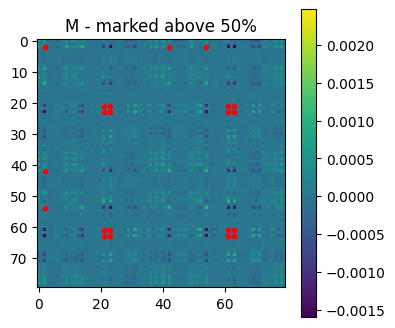

In [118]:
# fit the graph
time0 = time.time()
gd_opt_params['Theta0'] = None
fact_B, fact_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_params, gd_opt_params, seed)
fact_M = fact_B.T @ fact_B
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(fact_M, fig_params)

## SDP-GLMNN

In [21]:
# eng.quit()

In [22]:
# start the matlab engine
eng = matlab.engine.start_matlab()

In [23]:
eng.cd(r'../15_cheng/lmnn-offtheshelf/', nargout=0)

In [14]:
# fit the graph
time0 = time.time()
(cvx_M, cvx_delta, cvx_status) = eng.lmnn_cvx_python(swap_path_matlab, idstr, gamma, beta, nargout=3)

Elapsed time is 0.135929 seconds.
Elapsed time is 0.097807 seconds.
n_delta = 15000
Elapsed time is 0.244404 seconds.
 
Calling SeDuMi 1.3.4: 32080 variables, 15000 equality constraints
------------------------------------------------------------
SeDuMi 1.3.4 by AdvOL, 2005-2008 and Jos F. Sturm, 1998-2003.
Alg = 2: xz-corrector, Adaptive Step-Differentiation, theta = 0.250, beta = 0.500


EngineError: MATLAB function cannot be evaluated

cvx_status:  Solved
Elapsed  time: 86.784103 sec


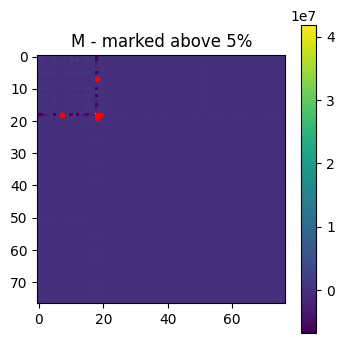

In [19]:
print('cvx_status: ', cvx_status)
cvx_M = np.array(cvx_M)
cvx_delta = np.array(cvx_delta).reshape(-1)
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(cvx_M, fig_params)

In [20]:
# compute the objective matrix required to compute the training loss
cvx_V = eng.get_objective_variables_ready_python(swap_path_matlab, idstr)
cvx_V = np.array(cvx_V)

In [21]:
cvx_V

array([[ 0.04132483,  0.04139413,  0.03459456, ..., -0.09248525,
         0.03879178,  0.17308389],
       [ 0.04139413,  0.04148952,  0.0324306 , ..., -0.09135734,
         0.03962292,  0.1745608 ],
       [ 0.03459456,  0.0324306 ,  0.21908416, ..., -0.187202  ,
        -0.03307097,  0.04336958],
       ...,
       [-0.09248525, -0.09135734, -0.187202  , ...,  4.3307657 ,
         2.00356212, -0.03806085],
       [ 0.03879178,  0.03962292, -0.03307097, ...,  2.00356212,
         3.38321647,  1.71624055],
       [ 0.17308389,  0.1745608 ,  0.04336958, ..., -0.03806085,
         1.71624055,  4.40056954]])

## GDPA-GLMNN

In [24]:
# change matlab's folder
eng.cd(r'../lmnn-gdpa-2/', nargout=0)

starting SGML.
initial objective value = Inf
1: objective_previous - objective_current = Inf
2: objective_previous - objective_current = 22.322153
3: objective_previous - objective_current = 8.452357
4: objective_previous - objective_current = 0.126262
5: objective_previous - objective_current = 0.000000
1: objective_previous - objective_current = 0.017623
2: objective_previous - objective_current = 0.000000
converged objective value = 136.4785
minimal eigenvalue of M = -0.0001
num_LP_rowcol = 240, num_LP_full = 2done with SGML.
Elapsed  time: 36.328026 sec


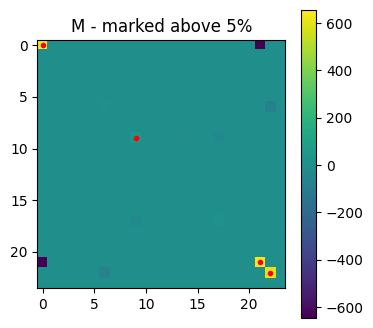

In [25]:
# fit the graph
time0 = time.time()
(gdpa_M, gdpa_delta, num_LP_rowcol, num_LP_full) = eng.lmnn_gdpa_python(swap_path_matlab, idstr, gamma, beta, nargout=4)
gdpa_M = np.array(gdpa_M)
gdpa_delta = np.array(gdpa_delta).reshape(-1)
print('Elapsed  time: {:.6f} sec'.format(time.time()-time0))
visualize_M(gdpa_M, fig_params)

In [26]:
# compute the objective matrix required to compute the training loss
gdpa_V = eng.get_objective_variables_ready_python(swap_path_matlab, idstr)
gdpa_V = np.array(gdpa_V)

# sanity check - V should be the same for both CVX and GDPA
assert (gdpa_V == cvx_V).all()

NameError: name 'cvx_V' is not defined

In [25]:
# close the matlab engine
eng.quit()

## Logistic Regression (benchmark)

In [111]:
# instantiate the logistic regression model
lgrg = LogisticRegression(penalty='none', max_iter=1000000)
# fit model
lgrg = lgrg.fit(train_data['des'], train_data['lbls'])

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Validation

In [119]:
import importlib
importlib.reload(sg)

<module 'simgraph.my_simgraph' from '/home/yasamanparhizkar/Documents/yorku/01_thesis/simgraph/code/my_packages/simgraph/my_simgraph.py'>

In [120]:
show_edges = False

In [121]:
# Fact-GLR&trace
fact_val_acc, fact_y_est, fact_t = sg.get_acc(fact_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, 'cat', seed, show_edges)
print('Elapsed time: {:.6f} sec'.format(fact_t))
print('GLR val. acc. = {:.6f}%'.format(fact_val_acc*100))

Elapsed time: 0.075935 sec
GLR val. acc. = 32.000000%


In [42]:
# CVX-LMNN
cvx_val_acc, cvx_y_est, cvx_t = sg.get_acc(cvx_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
# NOTE: sg_params['edges_vv'] and sg_params['edges_vt'] are fixed now
print('Elapsed time: {:.6f} sec'.format(cvx_t))
print('SDP-GLMNN val. acc. = {:.2f}%'.format(cvx_val_acc*100))

Elapsed time: 0.110075 sec
CVX-LMNN val. acc. = 50.00%


In [43]:
# GDPA-LMNN
gdpa_val_acc, gdpa_y_est, gdpa_t = sg.get_acc(gdpa_M, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed, show_edges)
print('Elapsed time: {:.6f} sec'.format(gdpa_t))
print('GDPA-GLMNN val. acc. = {:.2f}%'.format(gdpa_val_acc*100))

Elapsed time: 0.110527 sec
GDPA-LMNN val. acc. = 48.00%


In [112]:
# LogReg
time0 = time.time()
lgrg_val_acc = lgrg.score(val_data['des'], val_data['lbls'])
lgrg_y_est = lgrg.predict(val_data['des'])
print('Elapsed time: {:.6f} sec'.format(time.time()-time0))
print('LogReg val. acc. = {:.2f}%'.format(lgrg_val_acc*100))

Elapsed time: 0.002261 sec
LogReg val. acc. = 28.00%


# Compare final loss values

In [29]:
# CVX-LMNN
cvx_loss = np.sum(cvx_M * cvx_V.T) + beta * np.sum(cvx_delta)
print('CVX-LMNN loss: {:.4f}'.format(cvx_loss))

In [30]:
# GDPA-LMNN
gdpa_loss = np.sum(gdpa_M * gdpa_V.T) + beta * np.sum(gdpa_delta)
print('GDPA-LMNN loss: {:.4f}'.format(gdpa_loss))

GDPA-LMNN loss: 136.4785


In [39]:
# Fact-GLR&trace
fact_loss = sg.cnstr_glr(fact_B, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])
print('Fact-GLR&trace loss: {:.4f}'.format(fact_loss))

Fact-GLR&trace loss: 0.0851


## LMNN loss with Fact-GLR&trace optimized metric

In [33]:
edges_tt = np.array(sg_params['edges_tt'])
x = train_data['lbls']
feature = train_data['des']

In [34]:
e2 = 0
for edge_i in range(edges_tt.shape[0]):
    n_i = edges_tt[edge_i,0]
    n_j = edges_tt[edge_i,1]
    if x[n_i] == x[n_j]:
        n_ls = np.append(edges_tt[edges_tt[:,1] == n_i,0], edges_tt[edges_tt[:,0] == n_i,1], axis=0)
        for li in range(n_ls.shape[0]):
            if x[n_ls[li]] == -1*x[n_i]:
                f_ij = feature[n_i] - feature[n_j]
                f_il = feature[n_i] - feature[n_ls[li]]
                F_ijl = np.outer(f_ij, f_ij) - np.outer(f_il, f_il)
                temp = np.sum(fact_M * F_ijl) + gamma
                if temp >= 0:
                    e2 = e2 + temp

cvx_loss_with_fact = np.sum(fact_M * cvx_V.T) + beta * e2
print('CVX-LMNN loss with Fact-GLR&trace metric: {:.4f}'.format(cvx_loss_with_fact))

CVX-LMNN loss with Fact-GLR&trace metric: 1444.7015
